# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x77fdd35da5d0>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

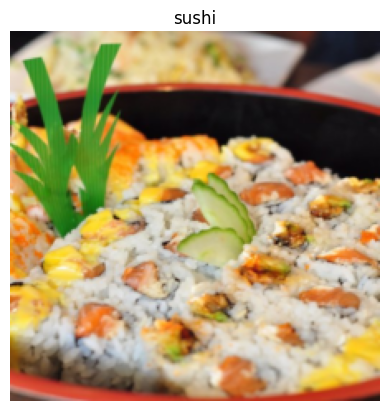

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [9]:
# Create the TransformerEncoderLayer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                             nhead = 12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first = True,
                                                             norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [10]:
torch_transformer_enconder = torch.nn.TransformerEncoder(encoder_layer=torch_transformer_encoder_layer,
                                                         num_layers=12)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [11]:
# 1. Create a class called PathEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self, in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from table1 for ViT-Base
    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisbile by patch size, image shape: {image_resolution}, patch size: {self.patch_size} "

    # Perfomr the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order
    # (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)

In [12]:
class ViT(nn.Module):
  """
  Creates a Vision Transformer architecture with ViT-Base hyperparameters by default
  """
  # 2. Initialize the class with the hyperparameters
  def __init__(self,
               img_size: int = 224, # training resolution from table 3
               in_channels: int = 3, # number of channels in input image
               patch_size: int = 16, # patch size
               num_transformers_layer: int =12, # layers from table 1 for ViT-B
               embedding_dim: int = 768, # hidden size D from table 1 for ViT-B
               mlp_size: int = 3072, # MLP size from table 1 for ViT-B
               num_heads: int = 12, # heads from table 1 for ViT-B
               attn_dropout: float = 0, # dropout for attention projection
               mlp_dropout: float = 0.1, # dropout for dense/MLP layers
               embedding_dropout: float = 0.1, # dropout for patch and position embeddings
               num_classes: int = 1000): # default for ImageNet
    super().__init__()

    # 3. Make the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # 4. Calculate number of patches (height * width / patch^2)
    self.number_patches = int(img_size * img_size) // patch_size**2

    # 5. Create learnable class embedding (need to be at the front of sequence of patch embedding)
    self.class_embedding = nn.Parameter(data = torch.rand(1, 1, embedding_dim),
                                         requires_grad = True)

    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(data = torch.rand(1, self.number_patches +1, embedding_dim),
                                           requires_grad= True)

    # 7. Create dropout value
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # 9. Create transfomer layer
    torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
                                                             nhead = num_heads,
                                                             dim_feedforward=mlp_size,
                                                             dropout=mlp_dropout,
                                                             activation="gelu",
                                                             batch_first = True,
                                                             norm_first = True)

    # 9. Create transfomer block
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer = torch_transformer_encoder_layer,
                                                   num_layers = num_transformers_layer)

    # 10. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape= embedding_dim),
        nn.Linear(in_features= embedding_dim,
                  out_features= num_classes)
    )

  # 11. Create a forward method
  def forward(self,x):
    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size
    class_token  = self.class_embedding.expand(batch_size, -1, -1)

    # 14. Create patch embedding
    x = self.patch_embedding(x)

    # 14. Concat class token embedding and patch embedding
    x = torch.cat((class_token, x), dim = 1)

    # 15. Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # 16. Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # 17. Pass patch, positin and class embedding through transformer encoder layers
    x = self.transformer_encoder(x)

    # 18. Put 0th index logit through the classifier
    x = self.classifier(x[:,0])

    return x

In [13]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((768,), eps=1e-05

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [14]:
%%writefile going_modular/vit.py

"""
Contains what need it for recreating the ViT architecture.
"""
import torch
import torchvision
from torchvision import transforms
from torch import nn


# 1. Create a class called PathEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self, in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from table1 for ViT-Base
    super().__init__()

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisbile by patch size, image shape: {image_resolution}, patch size: {self.patch_size} "

    # Perfomr the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order
    # (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)



class ViT(nn.Module):
  """
  Creates a Vision Transformer architecture with ViT-Base hyperparameters by default
  """
  # 2. Initialize the class with the hyperparameters
  def __init__(self,
               img_size: int = 224, # training resolution from table 3
               in_channels: int = 3, # number of channels in input image
               patch_size: int = 16, # patch size
               num_transformers_layer: int =12, # layers from table 1 for ViT-B
               embedding_dim: int = 768, # hidden size D from table 1 for ViT-B
               mlp_size: int = 3072, # MLP size from table 1 for ViT-B
               num_heads: int = 12, # heads from table 1 for ViT-B
               attn_dropout: float = 0, # dropout for attention projection
               mlp_dropout: float = 0.1, # dropout for dense/MLP layers
               embedding_dropout: float = 0.1, # dropout for patch and position embeddings
               num_classes: int = 1000): # default for ImageNet
    super().__init__()

    # 3. Make the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # 4. Calculate number of patches (height * width / patch^2)
    self.number_patches = int(img_size * img_size) // patch_size**2

    # 5. Create learnable class embedding (need to be at the front of sequence of patch embedding)
    self.class_embedding = nn.Parameter(data = torch.rand(1, 1, embedding_dim),
                                         requires_grad = True)

    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(data = torch.rand(1, self.number_patches +1, embedding_dim),
                                           requires_grad= True)

    # 7. Create dropout value
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # 9. Create transfomer layer
    torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dim,
                                                             nhead = num_heads,
                                                             dim_feedforward=mlp_size,
                                                             dropout=mlp_dropout,
                                                             activation="gelu",
                                                             batch_first = True,
                                                             norm_first = True)

    # 10. Create transfomer block
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer = torch_transformer_encoder_layer,
                                                   num_layers = num_transformers_layer)

    # 11. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape= embedding_dim),
        nn.Linear(in_features= embedding_dim,
                  out_features= num_classes)
    )

  # 12. Create a forward method
  def forward(self,x):
    # 13. Get batch size
    batch_size = x.shape[0]

    # 14. Create class token embedding and expand it to match the batch size
    class_token  = self.class_embedding.expand(batch_size, -1, -1)

    # 15. Create patch embedding
    x = self.patch_embedding(x)

    # 16. Concat class token embedding and patch embedding
    x = torch.cat((class_token, x), dim = 1)

    # 17. Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # 18. Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # 19. Pass patch, positin and class embedding through transformer encoder layers
    x = self.transformer_encoder(x)

    # 20. Put 0th index logit through the classifier
    x = self.classifier(x[:,0])

    return x

Writing going_modular/vit.py


In [15]:
from going_modular import vit

model_test = ViT(img_size=224, patch_size=32, num_classes=3)
print(model_test)

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): LayerNorm((768,), eps=1e-05

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [16]:
# imports
import torch
import torchvision

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Download 20 percenen training data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [17]:
# Setup training directory paths
train_dir_20_percent = data_20_percent_path / "train"
test_dir_20_percent = data_20_percent_path / "test"

In [18]:
# Get pretrained weights
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_model = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 52.3MB/s]


In [19]:
# Get automatic transforms from the pretrained weights
pre_trained_transforms = pretrained_weights.transforms()

# Create training and testing dataloaders
train_dataloader_20_percent_pretrained, test_dataloader_20_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                                   test_dir = test_dir_20_percent,
                                                                                                                   transform = pre_trained_transforms,
                                                                                                                   batch_size = 32)

In [20]:
# Freezing the layer of the pretrained mode
for param in pretrained_model.parameters():
  param.requires_grad = False

# Change the classifier part of the model
pretrained_model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [21]:
# Optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_model.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [22]:
# Train the model
set_seeds()
pretrained_model_20_percent_results = engine.train(model= pretrained_model,
                                                   train_dataloader = train_dataloader_20_percent_pretrained,
                                                   test_dataloader = test_dataloader_20_pretrained,
                                                   optimizer = optimizer,
                                                   loss_fn = loss_fn,
                                                   epochs = 10,
                                                   device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7634 | train_acc: 0.7125 | test_loss: 0.2652 | test_acc: 0.9347


KeyboardInterrupt: 

In [ ]:
# Plot loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_model_20_percent_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# Get pretrained_weights
pretrained_weights_v1 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

# Setup model
pretrained_model_v1 = torchvision.models.vit_b_16(weights=pretrained_weights)


In [ ]:
# Get automatic transforms from the pretrained weights
pre_trained_transforms_v1 = pretrained_weights_v1.transforms()

# Create training and testing dataloaders
train_dataloader_20_percent_pretrained_v1, test_dataloader_20_pretrained_v1, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                                   test_dir = test_dir_20_percent,
                                                                                                                   transform = pre_trained_transforms_v1,
                                                                                                                   batch_size = 32)

In [ ]:
# Freezing the layer of the pretrained mode
for param in pretrained_model_v1.parameters():
  param.requires_grad = False

# Change the classifier part of the model
pretrained_model_v1.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
# Optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_model.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Train the model
set_seeds()
pretrained_model_20_percent_results_v1 = engine.train(model= pretrained_model,
                                                   train_dataloader = train_dataloader_20_percent_pretrained_v1,
                                                   test_dataloader = test_dataloader_20_pretrained_v1,
                                                   optimizer = optimizer,
                                                   loss_fn = loss_fn,
                                                   epochs = 10,
                                                   device = device)

In [ ]:
# Plot loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_model_20_percent_results_v1)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

In [ ]:
# TODO: your explanations of the above terms